# CutMix, MixUp, and RandAugment image augmentation with KerasCV

## Imports & setup


In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/MyDrive/[2024-2025]AN2DL/Homework1



Mounted at /gdrive
/gdrive/MyDrive/[2024-2025]AN2DL/Homework1


In [ ]:
%%capture
!pip install keras_cv
import keras_cv

We begin by importing all required packages:

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import matplotlib.pyplot as plt


# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
import keras as tfk
from keras.layers import Input, Dense, Dropout, Lambda, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from keras import layers as tfkl
import keras_cv

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(f"Tensorflow version -> {tf.__version__}")
print(f"Keras version -> {tfk.__version__}")

# Import other libraries
import requests
from io import BytesIO
import cv2
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import seaborn as sns


# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

Tensorflow version -> 2.17.1
Keras version -> 3.5.0


## Data loading


In [ ]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
tfds.disable_progress_bar()

import numpy as np


data = np.load(
        'cleaned_data_dedup_balanced.npz'
)
X = data['images']
y = data['labels']


# data, dataset_info = tfds.load("oxford_flowers102", with_info=True, as_supervised=True)
# train_steps_per_epoch = dataset_info.splits["train"].num_examples // BATCH_SIZE
# val_steps_per_epoch = dataset_info.splits["test"].num_examples // BATCH_SIZE

In [ ]:
class_mapping = {
    0: "Basophil",
    1: "Eosinophil",
    2: "Erythroblast",
    3: "Immature granulocytes",
    4: "Lymphocyte",
    5: "Monocyte",
    6: "Neutrophil",
    7: "Platelet"
}

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed, stratify=y_temp)

class_names =  list(class_mapping.values())

#y_train = tfk.utils.to_categorical(y_train, num_classes=len(class_names))
#y_val = tfk.utils.to_categorical(y_val, num_classes=len(class_names))

data_train = tf.data.Dataset.from_tensor_slices((X_train, y_train.flatten())).batch(BATCH_SIZE, drop_remainder=True)
data_val = tf.data.Dataset.from_tensor_slices((X_val, y_val.flatten())).batch(BATCH_SIZE, drop_remainder=True)
data_test = tf.data.Dataset.from_tensor_slices((X_test, y_test.flatten())).batch(BATCH_SIZE, drop_remainder=True)

print(data_val)
#train_steps_per_epoch = X.shape[0] // BATCH_SIZE
#val_steps_per_epoch = X.shape[0] // BATCH_SIZE

<_BatchDataset element_spec=(TensorSpec(shape=(32, 96, 96, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(32,), dtype=tf.uint8, name=None))>


In [ ]:
IMAGE_SIZE = (96, 96)
num_classes = 8


def to_dict(image, label):
    #image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, num_classes)

    return {"images": image, "labels": label}


def prepare_dataset(dataset, split):
    if split == "train":
        return (
            dataset.shuffle(10 * BATCH_SIZE)
            .map(to_dict, num_parallel_calls=AUTOTUNE)
        )
    else:
        return dataset.map(to_dict, num_parallel_calls=AUTOTUNE)


def load_dataset(split="train"):
    if split == "train":
      dataset = data_train
    elif split == "val":
      dataset = data_val

    else:
      dataset = data_test
    return prepare_dataset(dataset, split)


train_dataset = load_dataset()

Let's inspect some samples from our dataset:

(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)


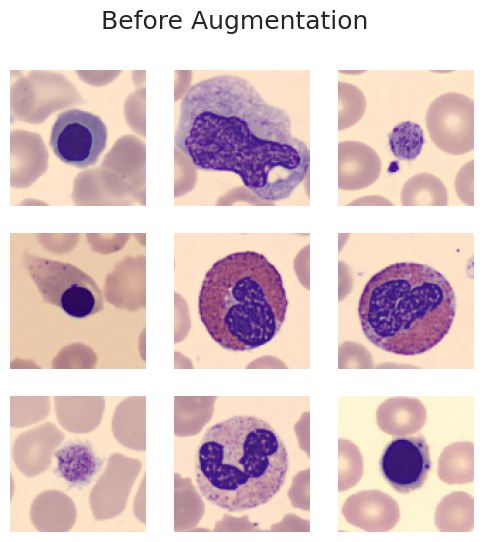

In [ ]:

def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        print(images.shape)
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()


visualize_dataset(train_dataset, title="Before Augmentation")

## RandAugment

[RandAugment](https://arxiv.org/abs/1909.13719)


In [ ]:
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=1.0,
)


def apply_rand_augment(inputs):
    inputs["images"] = rand_augment(inputs["images"])
    return inputs


train_dataset = load_dataset().map(apply_rand_augment, num_parallel_calls=AUTOTUNE)

Finally, let's inspect some of the results:

(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)


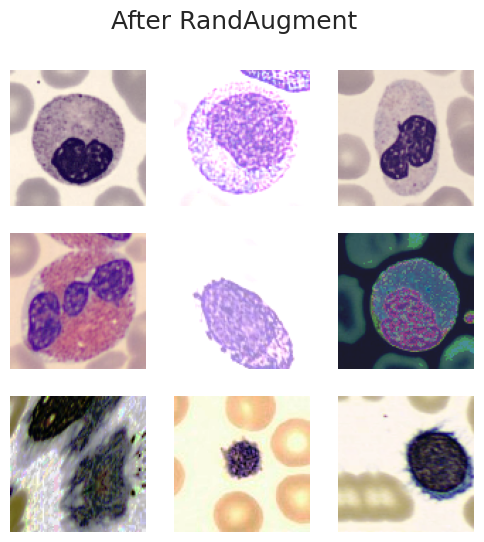

In [ ]:
visualize_dataset(train_dataset, title="After RandAugment")

## CutMix and MixUp: generate high-quality inter-class examples

- [CutMix: Train Strong Classifiers](https://arxiv.org/abs/1905.04899)
- [MixUp: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412)


(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)


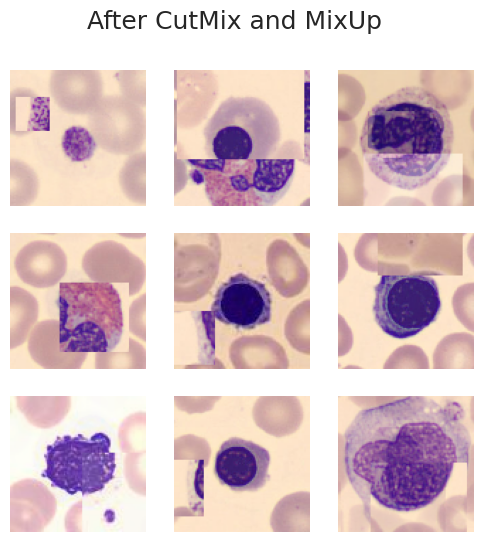

In [ ]:
cut_mix = keras_cv.layers.CutMix()
mix_up = keras_cv.layers.MixUp()


def cut_mix_and_mix_up(samples):
    samples = cut_mix(samples, training=True)
    samples = mix_up(samples, training=True)
    return samples


train_dataset = load_dataset().map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)

visualize_dataset(train_dataset, title="After CutMix and MixUp")

Great! Looks like we have successfully added `CutMix` and `MixUp` to our preprocessing
pipeline.

## Training a CNN

(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)


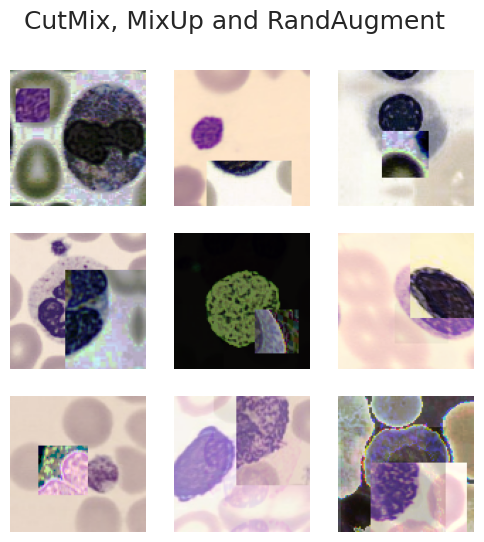

In [ ]:

def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels


train_dataset = (
    load_dataset()
    .map(apply_rand_augment, num_parallel_calls=AUTOTUNE)
    .map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)
)

visualize_dataset(train_dataset, "CutMix, MixUp and RandAugment")

train_dataset = train_dataset.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)

val_dataset = load_dataset(split="val")
val_dataset = val_dataset.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)

test_dataset = load_dataset(split="test")
test_dataset = test_dataset.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)

train_dataset = train_dataset.prefetch(AUTOTUNE)
test_dataset = test_dataset.prefetch(AUTOTUNE)


In [ ]:
input_shape = (96, 96, 3)
print(input_shape)

import tensorflow.keras as tfk
import keras.layers as tfkl
from keras.layers import Dense

EfficientNet = tfk.applications.EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling=None,
)

output_shape = 8

def efficientNet_tl(input_shape=input_shape, output_shape=output_shape, name="EfficientNet"):

  inputs = tfkl.Input(shape=input_shape, name='input_layer')

  x = inputs

  x = EfficientNet(x)

  x = tfk.layers.GlobalAveragePooling2D()(x)

  x = tfk.layers.BatchNormalization()(x)
  x = tfk.layers.Dropout(0.2)(x)

  x = Dense(128, activation='relu')(x)  # Optional dense layer for additional learning capacity

  x = tfk.layers.BatchNormalization()(x)
  x = tfk.layers.Dropout(0.2)(x)

  predictions = Dense(8, activation='softmax')(x)  # Adjusted to 8 classes

  # Create a new model with these layers
  model = tfk.Model(inputs=inputs, outputs=predictions, name=name)

  # Optionally, freeze layers of the base model if needed
  for layer in EfficientNet.layers:
      layer.trainable = False

  model.compile(
        loss=tfk.losses.CategoricalFocalCrossentropy(
            alpha=0.5,
            gamma=5.0,
            from_logits=False,
            label_smoothing=0.02,
            axis=-1,
            reduction='sum_over_batch_size',
            name='categorical_focal_crossentropy'
        ),
        optimizer=tfk.optimizers.RMSprop(),
        metrics=['accuracy']
    )

  return model

(96, 96, 3)


In [ ]:
for batch in train_dataset.take(1):
    print(batch[0].shape)
    print(batch[1].shape)
    break

(32, 96, 96, 3)
(32, 8)


Finally we train the model:

In [ ]:
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
    # tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=1e-5)
]

model = efficientNet_tl()
history = model.fit(
    train_dataset,
    epochs=300,
    validation_data=val_dataset,
    callbacks=callbacks,

).history

final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

file_name = "FOCAL-" + model.name + "_" + str(final_val_accuracy) + '.keras'

model.save(file_name)


Epoch 1/300
465/465 ━━━━━━━━━━━━━━━━━━━━ 102s 80ms/step - accuracy: 0.2485 - loss: 0.6599 - val_accuracy: 0.5981 - val_loss: 0.2366
Epoch 2/300
465/465 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.3117 - loss: 0.4999 - val_accuracy: 0.7645 - val_loss: 0.1464
Epoch 3/300
465/465 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.3364 - loss: 0.4600 - val_accuracy: 0.7387 - val_loss: 0.1577
Epoch 4/300
465/465 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.3646 - loss: 0.4409 - val_accuracy: 0.7468 - val_loss: 0.1443
Epoch 5/300
465/465 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.3720 - loss: 0.4312 - val_accuracy: 0.7893 - val_loss: 0.1324
Epoch 6/300
465/465 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.3764 - loss: 0.4299 - val_accuracy: 0.7214 - val_loss: 0.1412
Epoch 7/300
465/465 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.3934 - loss: 0.4220 - val_accuracy: 0.7505 - val_loss: 0.1382
Epoch 8/300
465/465 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.3887 - loss: 

In [ ]:
# test it
preds = model.evaluate(test_dataset)
print(preds)

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8537 - loss: 0.0930
[0.0965435728430748, 0.845366358757019]


In [ ]:
%ls

 basic_conv_gap2_89.91.keras              FocalCELoss_EfficientNet_98.61.keras
 cleaned_data_dedup_balanced.npz          FocalCELoss.keras
 cleaned_data_dedup.npz                   FOCAL-EfficientNet_85.13.keras
 cleaned_data.npz                         FOCAL_Fine_tuneEfficientNet_98.44.keras
 CreateTestingSet.ipynb                   Focal_loss.ipynb
 cut_mix_mix_up_and_rand_augment.ipynb   'Homework 1 - Melvin.ipynb'
 Data_cleaning.ipynb                      Homework_1_MobileNetV2.ipynb
 deduplicated_balanced_training_set.npz   mean_image.npy
 deduplicated_training_set.npz            model.py
 EfficientNet_84.2.keras                  ModelTraining.ipynb
 EfficientNet_96.19.keras                 prediction.txt
 EfficientNet_99.15.keras                 __pycache__/
 Final_tuned_for_3.keras                  requirements.txt
 Fine_Fine_tuneEfficientNet_98.78.keras   std_image.npy
 Fine_tune_class3.ipynb                   training_set.npz
 Fine_tuneEfficientNet_98.7.keras         train_wit

In [ ]:
def fine_tune_effNet():
    ft_model = tfk.models.load_model('FOCAL-EfficientNet_85.13.keras')

    ft_model.get_layer('efficientnetb7').trainable = True

    # Set all MobileNetV3Small layers as non-trainable
    for layer in ft_model.get_layer('efficientnetb7').layers:
        layer.trainable = False

    # Enable training only for Conv2D and DepthwiseConv2D layers
    for i, layer in enumerate(ft_model.get_layer('efficientnetb7').layers):
        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
            layer.trainable = True
            #print(i, layer.name, type(layer).__name__, layer.trainable)

    N_freeze = 500

    for layer in ft_model.get_layer('efficientnetb7').layers[:N_freeze]:
        layer.trainable = False
        #print(layer.name, layer.trainable)

    ft_model.compile(
        loss=tfk.losses.CategoricalFocalCrossentropy(
            alpha=0.5,
            gamma=5.0,
            from_logits=False,
            label_smoothing=0.02,
            axis=-1,
            reduction='sum_over_batch_size',
            name='categorical_focal_crossentropy'
        ),
        optimizer=tfk.optimizers.RMSprop(learning_rate = 1e-4),
        metrics=['accuracy']
    )


    return ft_model


In [ ]:
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
    # tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=1e-5)
]

model = fine_tune_effNet()
history = model.fit(
    train_dataset,
    epochs=300,
    validation_data=val_dataset,
    callbacks=callbacks,

).history

final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

file_name = "FOCAL_Fine_tune" +  model.name + "_" + str(final_val_accuracy) + '.keras'

model.save(file_name)

Epoch 1/300
465/465 ━━━━━━━━━━━━━━━━━━━━ 117s 91ms/step - accuracy: 0.4528 - loss: 0.3888 - val_accuracy: 0.8421 - val_loss: 0.0797
Epoch 2/300
465/465 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.5266 - loss: 0.3507 - val_accuracy: 0.9014 - val_loss: 0.0621
Epoch 3/300
465/465 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.5484 - loss: 0.3372 - val_accuracy: 0.9300 - val_loss: 0.0551
Epoch 4/300
465/465 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.5744 - loss: 0.3268 - val_accuracy: 0.9246 - val_loss: 0.0526
Epoch 5/300
465/465 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.5788 - loss: 0.3234 - val_accuracy: 0.9143 - val_loss: 0.0577
Epoch 6/300
465/465 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.5867 - loss: 0.3156 - val_accuracy: 0.9370 - val_loss: 0.0549
Epoch 7/300
465/465 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.6008 - loss: 0.3089 - val_accuracy: 0.9402 - val_loss: 0.0486
Epoch 8/300
465/465 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.6013 - loss: 

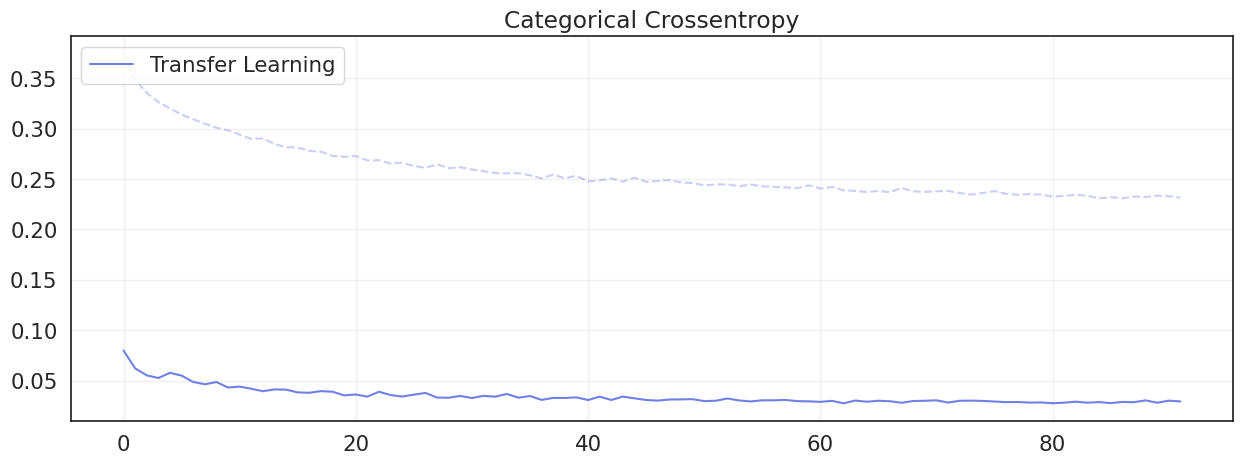

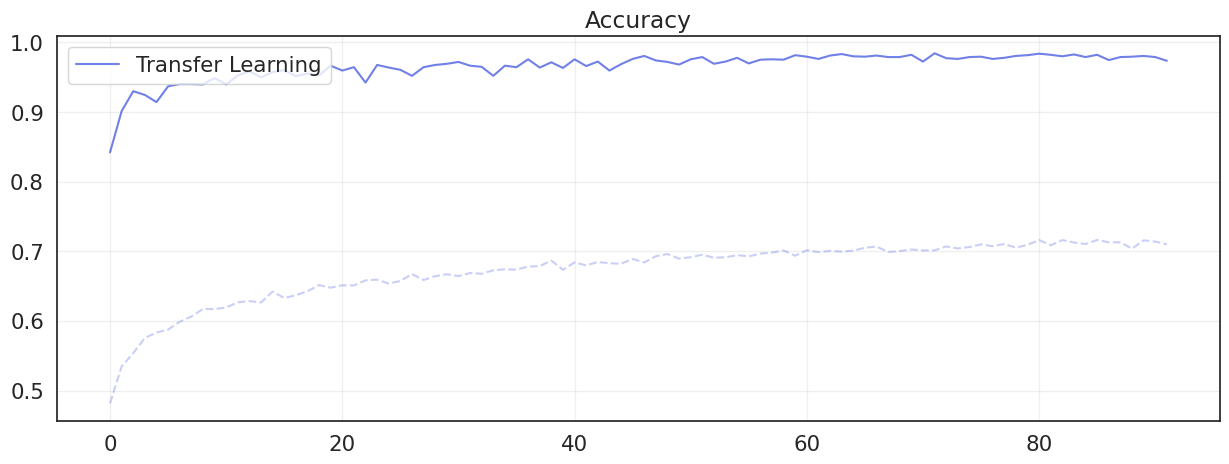

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
def fine_fine_tune_effNet():
    ft_model = tfk.models.load_model('FOCAL_Fine_tuneEfficientNet_98.44.keras')

    ft_model.get_layer('efficientnetb7').trainable = True

    # Set all MobileNetV3Small layers as non-trainable
    for layer in ft_model.get_layer('efficientnetb7').layers:
        layer.trainable = False

    # Enable training only for Conv2D and DepthwiseConv2D layers
    for i, layer in enumerate(ft_model.get_layer('efficientnetb7').layers):
        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
            layer.trainable = True
            #print(i, layer.name, type(layer).__name__, layer.trainable)

    N_freeze = 430

    for layer in ft_model.get_layer('efficientnetb7').layers[:N_freeze]:
        layer.trainable = False
        #print(layer.name, layer.trainable)

    ft_model.compile(
        loss=tfk.losses.CategoricalFocalCrossentropy(
            alpha=0.5,
            gamma=5.0,
            from_logits=False,
            label_smoothing=0.02,
            axis=-1,
            reduction='sum_over_batch_size',
            name='categorical_focal_crossentropy'
        ),
        optimizer=tfk.optimizers.RMSprop(learning_rate = 1e-5),
        metrics=['accuracy']
    )

    return ft_model


In [ ]:
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=4, factor=0.5, min_lr=1e-6)
]

model = fine_fine_tune_effNet()
history = model.fit(
    train_dataset,
    epochs=40,
    validation_data=val_dataset,
    callbacks=callbacks,

).history

final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

file_name = "FOCAL_Fine_Fine_tune" +  model.name + "_" + str(final_val_accuracy) + '.keras'

model.save(file_name)

Epoch 1/40
465/465 ━━━━━━━━━━━━━━━━━━━━ 118s 92ms/step - accuracy: 0.7057 - loss: 0.2379 - val_accuracy: 0.9811 - val_loss: 0.0281 - learning_rate: 1.0000e-05
Epoch 2/40
465/465 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.7223 - loss: 0.2309 - val_accuracy: 0.9817 - val_loss: 0.0284 - learning_rate: 1.0000e-05
Epoch 3/40
465/465 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.7171 - loss: 0.2351 - val_accuracy: 0.9828 - val_loss: 0.0279 - learning_rate: 1.0000e-05
Epoch 4/40
465/465 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.7060 - loss: 0.2323 - val_accuracy: 0.9822 - val_loss: 0.0281 - learning_rate: 1.0000e-05
Epoch 5/40
465/465 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.7081 - loss: 0.2321 - val_accuracy: 0.9822 - val_loss: 0.0282 - learning_rate: 1.0000e-05
Epoch 6/40
465/465 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.7137 - loss: 0.2313 - val_accuracy: 0.9833 - val_loss: 0.0276 - learning_rate: 1.0000e-05
Epoch 7/40
465/465 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/st

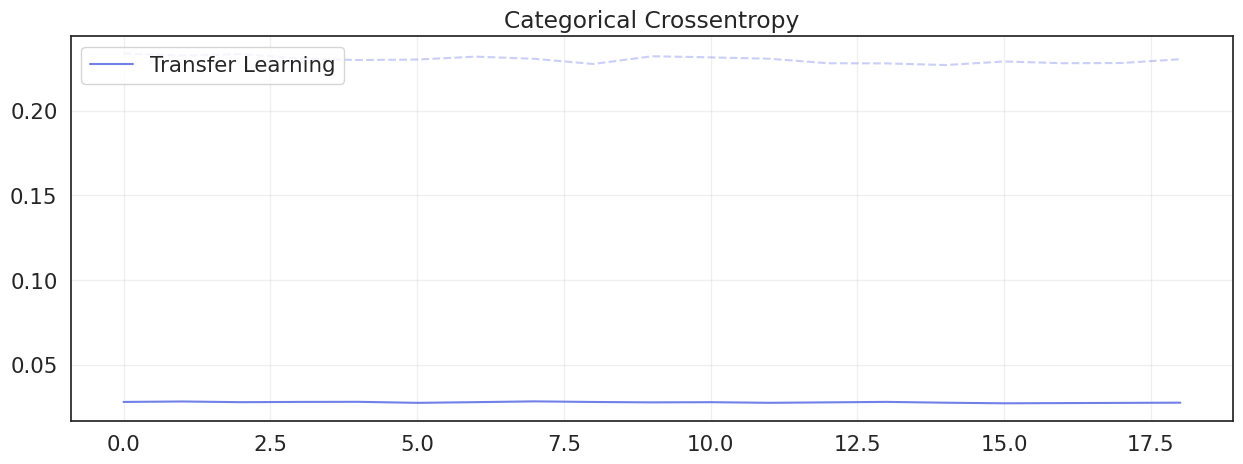

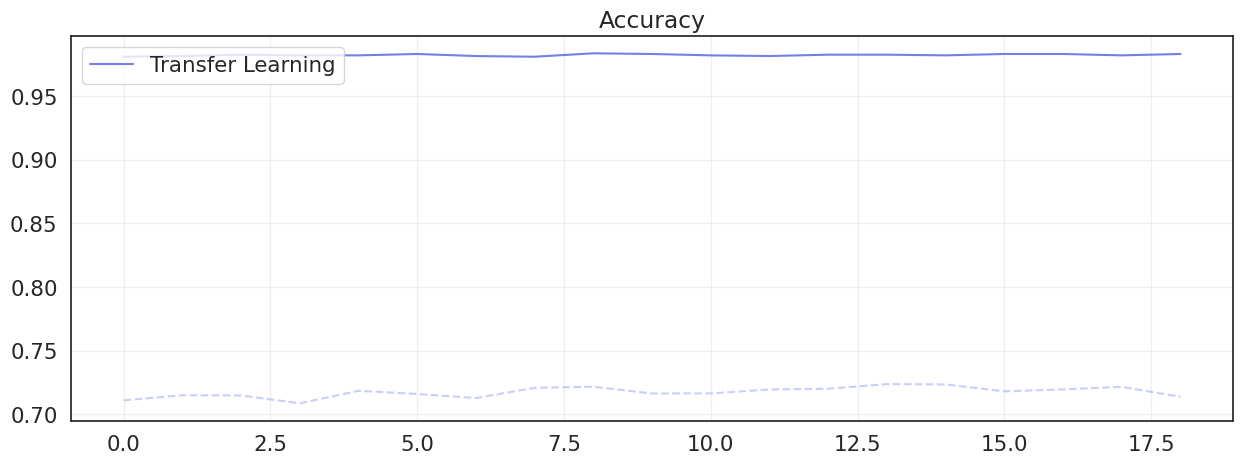

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()